# Multimodal optimization based on fitness sharing

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math

# Define funcion

In [2]:
def plotfunction(x1, x2):
    fun = np.cos(3 * x1) * np.sin(3 * x2) / 3
    return fun

In [3]:
def function(x):
    fun = np.cos(3 * x[:,0]) * np.sin(3 * x[:,1]) / 3
    return fun

## Initializing population

In [4]:
def initialpop(N,x_num,x_max,x_min):
    chromo = np.zeros([N,x_num + 3])
    for i in range(N):
        for j in range(x_num):
            chromo[i,j] = x_min[0,j]+(x_max[0,j]-x_min[0,j])*random.random()
    chromo[:,x_num] = function(chromo[:,0:x_num])
    
    return chromo

## Crossover

In [5]:
def crossover(chromo,pc,yita1,N,x_num,x_max,x_min):
    off_s = []
    index = list(np.arange(0,100,1))
    for i in range(N):
        pick_cros = random.sample(index , 2)
        while index[pick_cros[0]] == index[pick_cros[1]]:
            pick_cros = random.sample(index , 2)

        off_1 = chromo[pick_cros[0], :]
        off_2 = chromo[pick_cros[1], :]

        if random.random() < pc:
            for j in range(x_num):
                u = random.random()
                if u < 0.5:
                    gama = (2 * u)**(1 / (yita1 + 1))
                else:
                    gama = (1 / (2 * (1 - u)))**(1 / (yita1+1))

                off_1[j] = 0.5 * ((1 + gama) * off_1[j] + (1 - gama) * off_2[j])
                off_2[j] = 0.5 * ((1 - gama) * off_1[j] + (1 + gama) * off_2[j])

            #Modify if the boundary is exceeded
            off_1[0:x_num] = np.minimum(off_1[0:x_num], x_max.flatten())
            off_1[0:x_num] = np.maximum(off_1[0:x_num], x_min.flatten())
            off_2[0:x_num] = np.minimum(off_2[0:x_num], x_max.flatten())
            off_2[0:x_num] = np.maximum(off_2[0:x_num], x_min.flatten())

        off_s.append(off_1)
        off_s.append(off_2)

    off_s = np.array(off_s)
    indexx = list(np.arange(0,200,1)) 
    pick = random.sample(indexx,N)#N randomly selected from 2*N
    newchromo = off_s[pick,:]
    newchromo[:,x_num] = function(newchromo[:,0:x_num])
    
    return newchromo

## Mutation

In [6]:
def mutation(chromo,pm,yita2,N,x_num,x_max,x_min):
    for i in range(N):
        if random.random() < pm:
            # Each dimension has to be mutated by the formula
            for  j in range(x_num):
                u = random.random()
                if u < 0.5:
                    delta = (2 * u)**(1 / (yita2+1)) - 1
                else:
                    delta = 1 - (2 * (1 - u))**(1 / (yita2+1))

                chromo[i,j] = chromo[i,j] + delta

        chromo[i,0:x_num] = np.minimum(chromo[i,0:x_num], x_max.flatten())
        chromo[i,0:x_num] = np.maximum(chromo[i,0:x_num], x_min.flatten())

    chromo[:,x_num] = function(chromo[:,0:x_num])
    
    return chromo

## Fitness sharing

In [7]:
def sharingfitness(chromo,x_num,sigma,alpha):
    for i in range(len(chromo)):
        shsum = 0
        for j in range(len(chromo)):
            if i != j:
                dij = np.sqrt(np.sum((chromo[i,0:x_num] - chromo[j,0:x_num]) ** 2))

                if dij < sigma:
                    shij = 1 - (dij/sigma)**alpha
                else:
                    shij = 0

                shsum = shsum + shij

        if shsum != 0:
            chromo[i,x_num + 1] = chromo[i,x_num] / shsum
        else:
            chromo[i,x_num + 1] = 0
    return chromo

## Round-robin tournament selection

In [8]:
def tournamentselect(chromo_co,N,x_num,q):
    for i in range(len(chromo_co)):
        rank = 0
        pickindex = []
        while len(pickindex) < q:
            indindex = int(random.random() * len(chromo_co))
            while indindex in pickindex:
                indindex = int(random.random() * len(chromo_co))
            pickindex.append(indindex)
        for j in pickindex:
            if chromo_co[i, x_num + 1] > chromo_co[j, x_num + 1]:
                rank = rank + 1
        chromo_co[i, x_num + 2] = rank

    chromo_sort = np.array(sorted(chromo_co, key = lambda chromo_co:chromo_co[x_num + 2], reverse=True))
    chromo = chromo_sort[:N]
    
    return chromo

## Selection with out fitness sharing

In [9]:
def selection_normal(chromo_co,N,x_num,x_max,x_min):
    chromo_sort = np.array(sorted(chromo_co, key = lambda chromo_co:chromo_co[x_num],reverse=True))
    chromo = np.array(chromo_sort)[:N]
    return chromo

In [10]:
N = 100
x_num = 2
x_max = np.ones([1,x_num]) * 3
x_min = np.ones([1,x_num]) * -3
pc = 0.9 #Crossover probability
pm = 1 / x_num #Mutation probability
yita1 = 20
yita2 = 20
iteration = 2000 #Maximum number of iterations
alpha = 1
sigma = 0.7
q = 10

In [11]:
chromo = initialpop(N,x_num,x_max,x_min)

for i in range(iteration):
    parentchromo = chromo
    chromo_cros = crossover(parentchromo,pc,yita1,N,x_num,x_max,x_min)
    chromo_off = mutation(chromo_cros,pm,yita2,N,x_num,x_max,x_min)
    
    chromo_co = np.concatenate((chromo_off,chromo_off))
    chromo_co = sharingfitness(chromo_co,x_num,sigma,alpha)
    chromo = tournamentselect(chromo_co,N,x_num,q)
    
chromo_fs = chromo

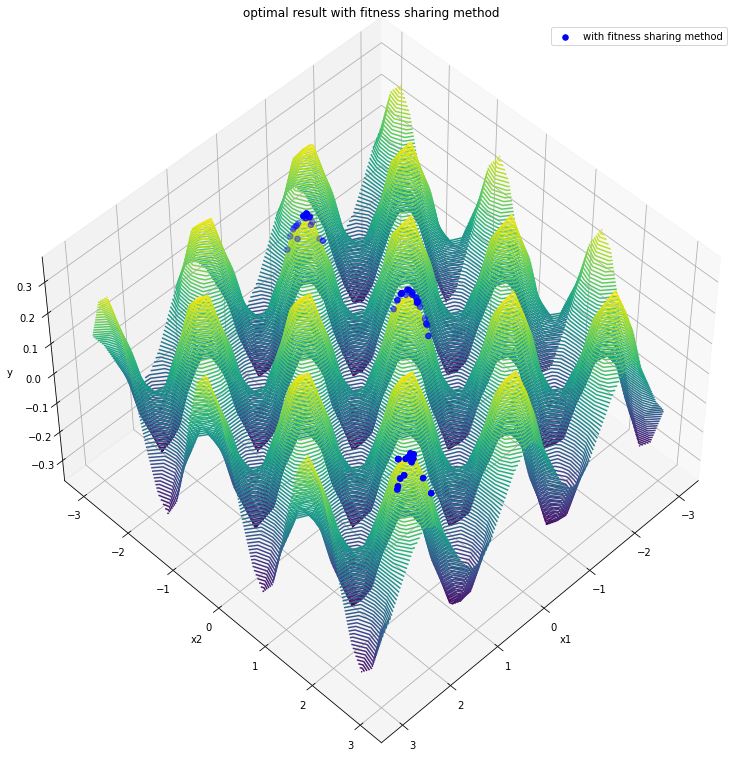

In [33]:
x1 = np.linspace(-3, 3, 30)
x2 = np.linspace(-3, 3, 30)
X1, X2 = np.meshgrid(x1, x2)
Y = plotfunction(X1, X2)

x1_opt_fs = chromo_fs[:,0]
x2_opt_fs = chromo_fs[:,1]
y_opt_fs = chromo_fs[:,x_num]

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig,auto_add_to_figure=False)
ax.contour3D(X1, X2, Y, 80)
ax.set_title('optimal result with fitness sharing method')
ax.scatter(x1_opt_fs,x2_opt_fs,y_opt_fs,s = 30,c = 'b',label='with fitness sharing method')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.view_init(50, 45)
ax.legend(loc=1)
fig.add_axes(ax)
plt.show()

In [13]:
chromo = initialpop(N,x_num,x_max,x_min)

for i in range(iteration):
    parentchromo = chromo
    chromo_cros = crossover(parentchromo,pc,yita1,N,x_num,x_max,x_min)
    chromo_off = mutation(chromo_cros,pm,yita2,N,x_num,x_max,x_min)
    
    chromo_co = np.concatenate((chromo_off,chromo_off))
    chromo = selection_normal(chromo_co,N,x_num,x_max,x_min)
    
chromo_normal = chromo

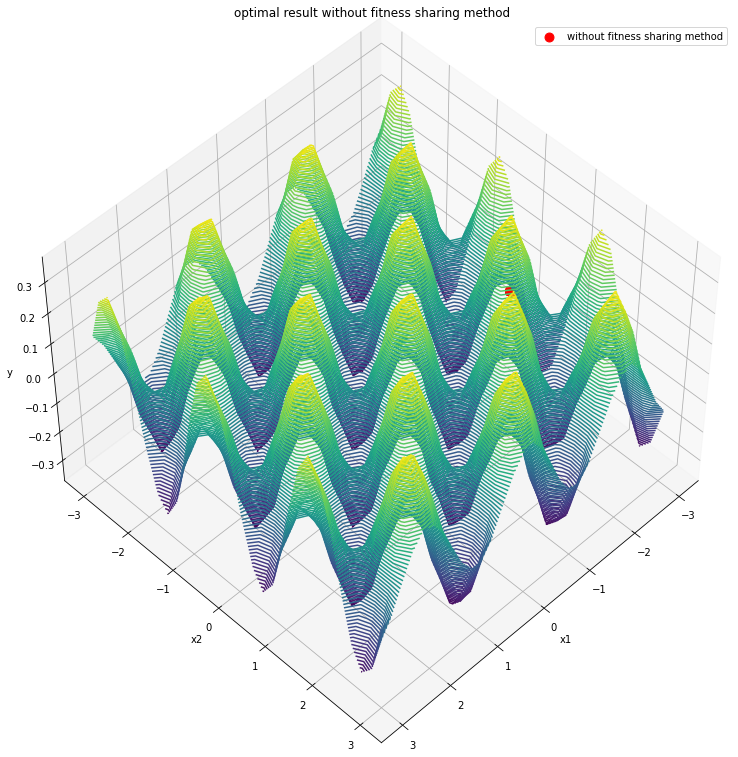

In [30]:
x1 = np.linspace(-3, 3, 30)
x2 = np.linspace(-3, 3, 30)
X1, X2 = np.meshgrid(x1, x2)
Y = plotfunction(X1, X2)

x1_opt_normal = chromo_normal[:,0]
x2_opt_normal = chromo_normal[:,1]
y_opt_normal = chromo_normal[:,x_num]

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig,auto_add_to_figure=False)
ax.contour3D(X1, X2, Y, 80)
ax.set_title('optimal result without fitness sharing method')
ax.scatter(x1_opt_normal,x2_opt_normal,y_opt_normal,s = 80,c = 'red',label='without fitness sharing method')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.view_init(50, 45)
ax.legend(loc=1)
fig.add_axes(ax)
plt.show()

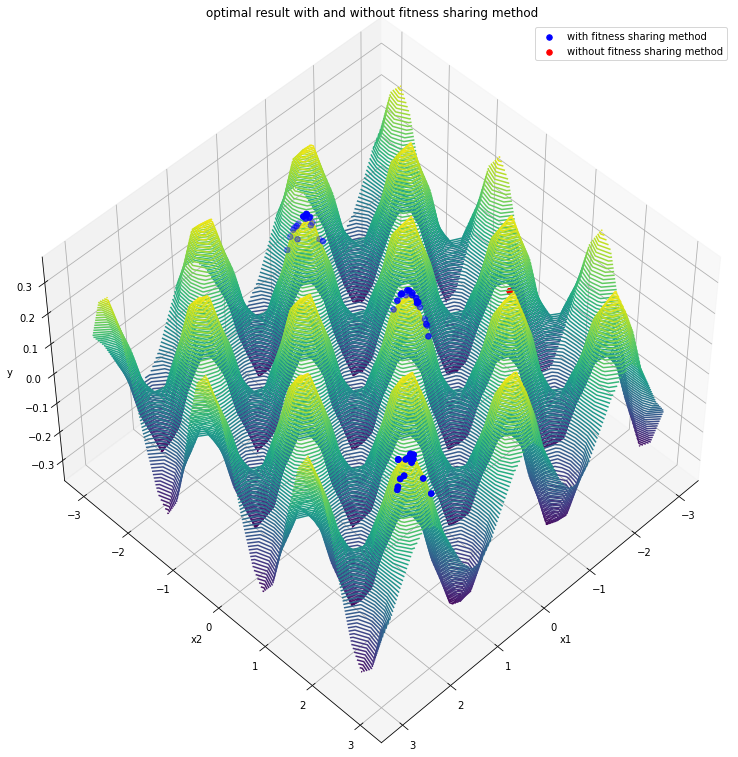

In [29]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig,auto_add_to_figure=False)
ax.set_title('optimal result with and without fitness sharing method')
ax.contour3D(X1, X2, Y, 80)
ax.scatter(x1_opt_fs,x2_opt_fs,y_opt_fs,s = 30,c = 'b',label='with fitness sharing method')
ax.scatter(x1_opt_normal,x2_opt_normal,y_opt_normal,s = 30,c = 'red',label='without fitness sharing method')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.view_init(50, 45)
ax.legend(loc=1)
fig.add_axes(ax)
plt.show()